In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install music21

    100% |████████████████████████████████| 18.0MB 2.1MB/s 
  Running setup.py bdist_wheel for music21 ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/53/8b/a6/be1921c60a68f0bea31c6b6a0a7b125badd61294d6a694407f
Successfully built music21


In [3]:
import os

batch_size = 1
max_length = 300
lstm_dim = 512
latent_dim = 2
epochs = 1000

work_dir = '/Users/masatoshi/repos/keras_composer/'
out_dir = os.path.join(work_dir, 'vae_new_output_101')

In [4]:
import os
import glob
from music21 import converter, instrument, note, chord, stream

def parse_midi_files(dir):
    notes = []
    songs = []
    file_list = []
    
    files = glob.glob(os.path.join(dir, '*.mid'))

    for file in files:
        song = []
        
        file_list.append(os.path.basename(file))
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                song.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                song.append('.'.join(str(n) for n in element.normalOrder))
        songs.append(song)
        notes += song

    return notes, songs, file_list

In [8]:
from keras.preprocessing.sequence import pad_sequences

notes, songs, file_list = parse_midi_files(os.path.join(work_dir,'midi_songs'))

pitchnames = sorted(set(notes))
n_vocab = len(pitchnames)

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict([[number, note] for note, number in note_to_int.items()])

encoded_songs = [[note_to_int[note] for note in song] for song in songs]

padded_songs = pad_sequences(encoded_songs, maxlen=max_length)

Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv782.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv783.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv781.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv780.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv784.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv785.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv778.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv786.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv779.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv774.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv775.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv777.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv776.mid
Parsing /Users/masatoshi/repos/keras_composer/midi_songs/bwv772.mid
Parsing /Users/masatoshi/repos/keras_composer/mi

In [9]:
import numpy as np

temp = np.zeros((padded_songs.shape[0], max_length, n_vocab))
temp[np.expand_dims(np.arange(padded_songs.shape[0]), axis=0).reshape(padded_songs.shape[0], 1), 
           np.repeat(np.array([np.arange(max_length)]), padded_songs.shape[0], axis=0), padded_songs] = 1

one_hot_encoded_songs = temp

In [10]:
from keras.models import Model
from keras.layers import Input, LSTM, CuDNNLSTM
from keras.layers.core import Dense

x = Input(shape=(max_length, n_vocab))

h = CuDNNLSTM(lstm_dim, return_sequences=False, name='lstm_1')(x)

z_mean = Dense(latent_dim)(h) # 潜在変数の平均 μ
z_log_var = Dense(latent_dim)(h) #潜在変数の分散 σのlog

encoder = Model(inputs=x, outputs=[z_mean, z_log_var])

In [11]:
from keras.utils import plot_model

plot_model(encoder, to_file=os.path.join(work_dir, 'vae_encoder.png'), show_shapes=True)

In [12]:
from keras import backend as K
from keras.layers import Lambda

# 潜在変数のサンプリング
# 平均と分散を受けて、潜在変数をサンプリングします。
# z = μ + εΣ
# εは標準正規分布
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

In [13]:
# Lambdaを使って式をwrap
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [14]:
from keras.layers import Dense, RepeatVector, TimeDistributed

decoder_input = Input(shape=(latent_dim,))

repeated_context = RepeatVector(max_length)(decoder_input)
h_decoded = CuDNNLSTM(lstm_dim, return_sequences=True, name='dec_lstm_1')(repeated_context)
decoder_output = TimeDistributed(Dense(n_vocab, activation='softmax'), name='decoded_mean')(h_decoded)

decoder = Model(inputs=decoder_input, outputs=decoder_output)

x_decoded = decoder(z)

In [16]:
plot_model(decoder, to_file=os.path.join(work_dir, 'vae_decoder.png'), show_shapes=True)

In [17]:
from keras.layers import Layer
from keras import metrics

class CustomVariationalLayer(Layer): # Layer classの継承
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded):
        x = K.flatten(x)
        x_decoded = K.flatten(x_decoded)
        xent_loss = max_length * metrics.binary_crossentropy(x, x_decoded) # 復元誤差: Reconstruction Error
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # 正則化項: KL Divergence
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs) # Layer class のadd_lossを利用
        return x # 実質的には出力は利用しない

In [18]:
y = CustomVariationalLayer()([x, x_decoded])
vae = Model(x, y) # xをinputにyを出力, 出力は実質関係ない
vae.compile(optimizer='rmsprop', loss=None) # CustomVariationalLayerで追加したLossを利用するのでここでのlossはNoneとする

In [19]:
plot_model(vae, to_file=os.path.join(work_dir, 'vae_all.png'), show_shapes=True)

In [0]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(os.path.join(out_dir, 'music_vae_log.csv'))

In [24]:
history = vae.fit(one_hot_encoded_songs, 
                            shuffle=True,
                            batch_size=batch_size, 
                            epochs=epochs, 
                            callbacks=[csv_logger], 
                            verbose=2)

Epoch 1/1000
 - 4s - loss: 13.5837
Epoch 2/1000
 - 2s - loss: 13.2289
Epoch 3/1000
 - 2s - loss: 12.4673
Epoch 4/1000
 - 2s - loss: 12.3992
Epoch 5/1000
 - 2s - loss: 12.3542
Epoch 6/1000
 - 2s - loss: 12.3710
Epoch 7/1000
 - 2s - loss: 12.3334
Epoch 8/1000
 - 2s - loss: 12.3340
Epoch 9/1000
 - 2s - loss: 12.3039
Epoch 10/1000
 - 2s - loss: 12.3174
Epoch 11/1000
 - 2s - loss: 12.3034
Epoch 12/1000
 - 2s - loss: 12.3002
Epoch 13/1000
 - 2s - loss: 12.2762
Epoch 14/1000
 - 2s - loss: 12.2702
Epoch 15/1000
 - 2s - loss: 12.2759
Epoch 16/1000
 - 2s - loss: 12.2421
Epoch 17/1000
 - 2s - loss: 12.2406
Epoch 18/1000
 - 2s - loss: 12.2517
Epoch 19/1000
 - 2s - loss: 12.2637
Epoch 20/1000
 - 2s - loss: 12.2348
Epoch 21/1000
 - 2s - loss: 12.2376
Epoch 22/1000
 - 2s - loss: 12.2162
Epoch 23/1000
 - 2s - loss: 12.2118
Epoch 24/1000
 - 2s - loss: 12.2013
Epoch 25/1000
 - 2s - loss: 12.2061
Epoch 26/1000
 - 2s - loss: 12.1819
Epoch 27/1000
 - 2s - loss: 12.1800
Epoch 28/1000
 - 2s - loss: 12.2112
E

In [0]:
vae.save_weights(os.path.join(out_dir, 'vae_weights.h5'))

In [0]:
vae.load_weights(os.path.join(out_dir, 'vae_weights.h5'))

In [0]:
def create_midi(prediction_output, file_path):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=file_path)

In [0]:
for i in range(len(one_hot_encoded_songs)):
    prediction_output = vae.predict(one_hot_encoded_songs[np.newaxis, i])
    prediction_indices = np.argmax(prediction_output, axis=2)
    prediction_song = [int_to_note[index] for index in prediction_indices[0]]
    create_midi(prediction_song, 
                os.path.join(out_dir, 'vae_new_1_{}.mid'.format(file_list[i])))

In [39]:
encoder_predictions = encoder.predict(one_hot_encoded_songs)
encoder_predictions

[array([[-0.02594699,  0.00100339],
        [-0.00365079,  0.01837124],
        [ 0.0192755 , -0.00072216],
        [-0.00859737, -0.02255215],
        [ 0.00512543,  0.02119087],
        [ 0.00476267,  0.00272977],
        [-0.01636326,  0.00885218],
        [-0.00648849, -0.00137275],
        [ 0.012515  ,  0.00510391],
        [-0.00487945, -0.01472363],
        [ 0.01493661,  0.01373338],
        [-0.00539184,  0.00811486],
        [ 0.0004161 , -0.01769741],
        [ 0.01046504, -0.00059549],
        [ 0.02825706, -0.00339537]], dtype=float32),
 array([[-0.00389085, -0.00056355],
        [-0.0051834 ,  0.00142809],
        [-0.00023731,  0.00379427],
        [-0.00458956,  0.00049319],
        [-0.00384728,  0.00351938],
        [-0.00497902,  0.00154   ],
        [-0.00181033,  0.00206973],
        [-0.00356603,  0.00192995],
        [-0.00128432,  0.00306626],
        [-0.00359012,  0.00381857],
        [-0.00264406,  0.00225217],
        [-0.00283483, -0.00163513],
        [-0

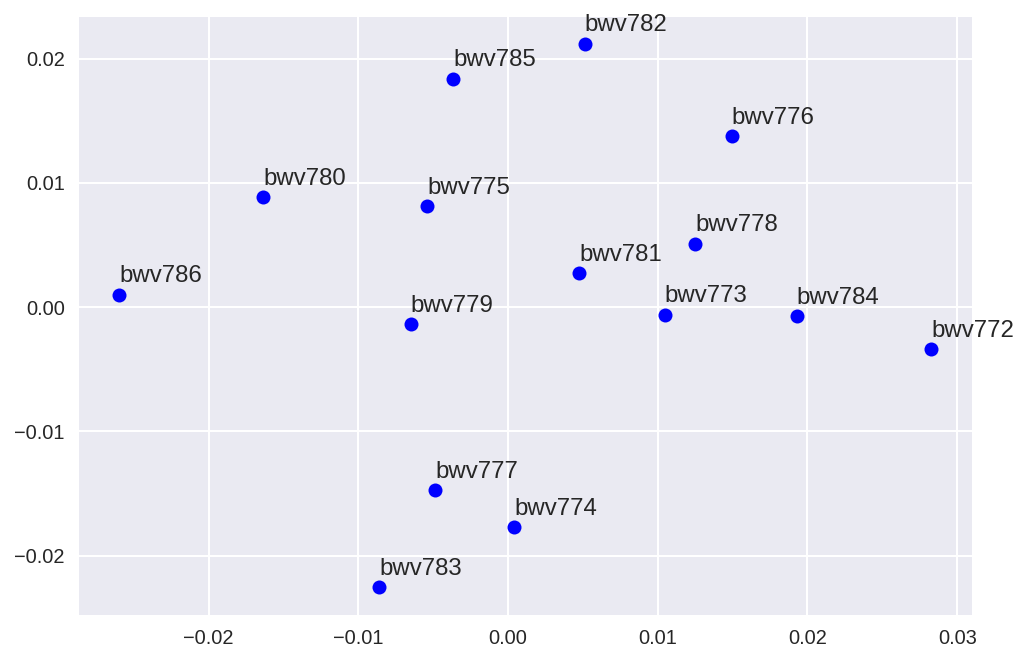

In [45]:
import matplotlib.pyplot as plt

plt.plot(encoder_predictions[0][:, 0],encoder_predictions[0][:, 1], 'bo')
for i, file in enumerate(file_list):
    plt.text(encoder_predictions[0][i, 0], encoder_predictions[0][i, 1] + 0.001, file.split('.')[0])
plt.show()

In [0]:
z0 = 0.0
z1 = 0.0
z_sample = np.array([[z0, z1]])
decoder_output = decoder.predict(z_sample)
decoded_indices = np.argmax(decoder_output, axis=2)
decoded_song = [int_to_note[index] for index in decoded_indices[0]]
create_midi(decoded_song, 
                os.path.join(out_dir, 'vae_new_1_{}_{}.mid'.format(z0, z1)))